In [1]:
import pandas as pd, io
import io
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))


def display_side_by_side(dfs: list, captions: list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


pd.set_option("display.max_rows", 20, "display.max_columns", 20)

df = pd.read_csv("transaction_history.csv", usecols=[1, 2, 3], parse_dates=[1])
df.columns = ['merchant', 'time', 'amount']
df['amount'] = df['amount'] / 100  # convert amount in cents to dollars so plots are in the US dollars unity
df


,merchant,time,amount
0,faa029c6b0,2034-06-17 23:34:14,63.49
1,ed7a7d91aa,2034-12-27 00:40:38,38.54
2,5608f200cf,2034-04-30 01:29:42,7.89
3,15b1a0d61e,2034-09-16 01:06:23,44.52
4,4770051790,2034-07-22 16:21:42,202.03
...,...,...,...
1513714,72d37bedbf,2034-06-21 13:47:51,52.74
1513715,5608f200cf,2034-04-20 02:23:59,7.54
1513716,fcbd1dae68,2033-09-19 14:02:33,132.03
1513717,9843e52410,2034-12-28 20:07:59,48.45


In [2]:
############# Initial description of the data grouped by merchant ###############################

grouped = df.groupby('merchant')
merchant_name = grouped.groups.keys()
keys_list = list(merchant_name)  # list with keys for each merchant

count_merchant = grouped['merchant'].count()
sum_merchant = grouped['amount'].sum()
time_interval = grouped['time'].max() - grouped['time'].min()
time_start = grouped['time'].min()
time_end = grouped['time'].max()

percentiles = [float(x / 100) for x in range(25, 100, 25)]

df_count = count_merchant.to_frame('Total number of transactions').describe(percentiles=percentiles).applymap(lambda x: f"{x:.0f}")
df_sum = sum_merchant.to_frame('Total amount').describe(percentiles=percentiles).applymap(lambda x: f"{x:.0f}")
df_time_start = time_start.to_frame('First transaction date with Co.').describe(datetime_is_numeric=True, percentiles=percentiles)
df_time_end = time_end.to_frame('Last Transaction date with Co.').describe(datetime_is_numeric=True, percentiles=percentiles)
df_time_interval = time_interval.to_frame('Interval between first and last transaction').describe(percentiles=percentiles)

# df_count = count_merchant.to_frame('# transactions').describe(percentiles=percentiles).applymap(lambda x: f"{x:.0f}")
# df_sum = sum_merchant.to_frame('Total $ amount').describe(percentiles=percentiles).applymap(lambda x: f"{x:.0f}")

display_side_by_side([df_count, df_sum, df_time_start, df_time_end, df_time_interval], ['number of transactions', 'total amount', 'time_start', 'time_end', 'time_interval'])


,Total number of transactions
count,14351
mean,105
std,528
min,1
25%,3
50%,11
75%,45
max,25512
,Total amount
count,14351


In [3]:
%%time

############# Creates a dictionary  with a TIME SERIES with weekly number of transactions and amount as value of the key merchant name #######################

dict_merchants = {}
freq = '1W'
periods = 105
new_datetime_range = pd.date_range(start='2033-01-01', freq=freq, periods=periods)
i = 0

count_list = []
amount_list = []

for name, group in grouped:

    dftmp = group
    dftmp = dftmp.reset_index().set_index('time')  # set the time as the index for data from each merchant
    dftmp.index.name = None

    dftmp = dftmp.resample(rule=freq).agg({"index": 'size', "amount": 'sum'})  # downsample data for days summing the number of transactions and amount for each day for each merchant
    dftmp = dftmp.set_axis(['count', 'amount'], axis=1, inplace=False)

    dftmpt = dftmp.resample(freq).sum().reindex(new_datetime_range, fill_value=0)  # extend the date range for every merchant from 2033-01-02 to 2034-12-31

    count_list.append(dftmp['count'].sum())  # save a list with number of weekly transactions to cache for each merchant
    amount_list.append(dftmp['amount'].sum())  # save a list with weekly amount to cache for each merchant

    dftmpt['amount'] = dftmpt['amount']
    dict_merchants[str(name)] = dftmpt  # save each merchant to a dictionary with merchant name as key
    if i % 1000 == 0:
        print(i)
    i += 1

# count_list=list((count_list / np.linalg.norm(count_list)))
# amount_list=list((amount_list / np.linalg.norm(amount_list)))


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
CPU times: user 1min 39s, sys: 256 ms, total: 1min 39s
Wall time: 1min 39s


In [4]:
%%time

#################### process data for the format required by KMeans from sklearn.cluster ##########################

i = 0
data = pd.DataFrame([])
for index in range(len(keys_list)):
    dftmp = dict_merchants[keys_list[index]]
    dftmp = dftmp['amount'].to_frame().transpose()
    #     dftmp = dftmp['amount'].append(dftmp['count']).to_frame().transpose()    ## Includes the weekly number of transactions as a time series. However, because number of transactions
    ## and weekly amount spent is higly correlated inserting these features won't change the classification
    ## but slows it down.

    data = data.append(dftmp, ignore_index=True)
    if i % 1000 == 0:
        print(i)
    i += 1
data_safe = data.copy()
# data=data_safe.copy()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
CPU times: user 28.1 s, sys: 260 ms, total: 28.4 s
Wall time: 28.5 s


In [5]:
# import statsmodels.api as sm
import seaborn as sns

sns.set()
from sklearn.cluster import KMeans
import random

# from sklearn.decomposition import PCA
# from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
# from sklearn.metrics import silhouette_score
# import scipy.cluster.hierarchy as shc


def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [6]:
##### Normalization and Scaling #####

############## StandardScaler ######################
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(data)
# data = pd.DataFrame(scaler.transform(data))  
# data = pd.DataFrame(normalize(data)) # Scales and normalises for each feature (day of the time series)
####################################################

############## Maximum Absolute Scaling ######################
data = ( data.transpose()  / data.transpose().max() ).transpose() # Normalises each merchant history so the time series behavior is preserved for each merchant
##############################################################


########inserts total_count and total_amount as features for each merchant. However these extra features do not help.################
# total_amount = pd.DataFrame(count_list) / np.linalg.norm(count_list)
# total_count = pd.DataFrame(amount_list) / np.linalg.norm(amount_list)
# data.insert(0,'total_count',total_count)
# data.insert(0,'total_amount',total_amount)                   
##############################################################

test_clean = clean_dataset(data).shape == data.shape  # tests for occurrences of NaN, np.inf, and -np.inf
print(test_clean)
data

True


,2033-01-02,2033-01-09,2033-01-16,2033-01-23,2033-01-30,2033-02-06,2033-02-13,2033-02-20,2033-02-27,2033-03-06,...,2034-10-29,2034-11-05,2034-11-12,2034-11-19,2034-11-26,2034-12-03,2034-12-10,2034-12-17,2034-12-24,2034-12-31
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,1.00000,0.000000,0.0,0.0,0.046918,0.0,0.000000
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14346,0.0,1.0,0.344004,0.285212,0.130816,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
14347,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
14348,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.125442,0.009867,0.010787,0.33457,0.010561,0.0,0.0,0.000000,0.0,0.000000
14349,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000


CPU times: user 1min 56s, sys: 28.1 s, total: 2min 24s
Wall time: 44.4 s


Text(0, 0.5, 'WCSS')

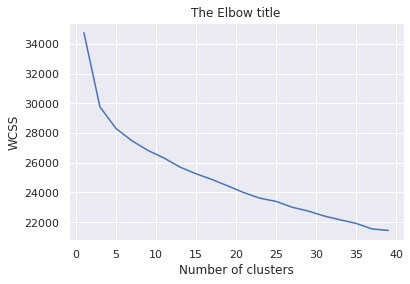

In [7]:
%%time

######### Calculates Within-Cluster Sum of Square as a function of number of clusters to find an good number of clusters of merchants ############


data_kmeans = data

wcss = []
wcss_range = range(1, 40, 2)

for i in wcss_range:
    kmeans = KMeans(i, n_init=10)
    kmeans.fit(data_kmeans)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

plt.plot(wcss_range, wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [8]:
%%time

##################### Fits and Predicts the cluster for each merchant using the K-means clustering algorithm ###############

n_clusters = 5  # based on the WCSS plot above this is a good number of clusters

kmeans = KMeans(n_clusters, max_iter=600, tol=0.00001, n_init=200)
kmeans.fit(data_kmeans)

identified_clusters = kmeans.fit_predict(data_kmeans)

CPU times: user 2min 44s, sys: 39.7 s, total: 3min 24s
Wall time: 57.1 s


In [9]:
########## Creats dictionaries to map identified clusters of K-means to the labels of merchants data ########################

dic_cluster = {}
for i in range(len(identified_clusters)):
    dic_cluster[keys_list[i]] = identified_clusters[i]

d = defaultdict(list)
for key, value in dic_cluster.items():
    d[value].append(key)

,________Total amount description_______
count,8882
mean,6581
std,43001
min,2
25%,246
50%,811
75%,3196
max,2369072
,________Total amount description_______
count,931


,______Total number of transactions______
count,8882
mean,32
std,192
min,1
25%,2
50%,6
75%,18
max,11222
,______Total number of transactions______
count,931


,______ Transactions time interval________
count,8882
mean,149 days 08:30:31.868498076
std,181 days 18:15:44.468195174
min,0 days 00:00:00
25%,5 days 06:34:33.750000
50%,64 days 10:57:02.500000
75%,245 days 02:09:43.750000
max,728 days 10:21:50
,______ Transactions time interval________
count,931


,_________Date first transaction_________
count,8882
mean,2034-01-07 09:27:42.163815680
min,2033-01-01 09:38:32
25%,2033-07-23 18:35:29
50%,2034-01-19 21:37:14
75%,2034-06-26 19:43:00.500000256
max,2034-12-31 06:19:35
,_________Date first transaction_________
count,931
mean,2034-03-26 00:42:23.169707520


,_________Date last transaction_________
count,8882
mean,2034-06-05 17:58:14.032306688
min,2033-01-02 01:07:20
25%,2034-02-08 00:04:47
50%,2034-08-01 19:25:53
75%,2034-11-08 09:29:23.249999872
max,2034-12-31 07:49:01
,_________Date last transaction_________
count,931
mean,2034-12-24 21:31:34.560686592


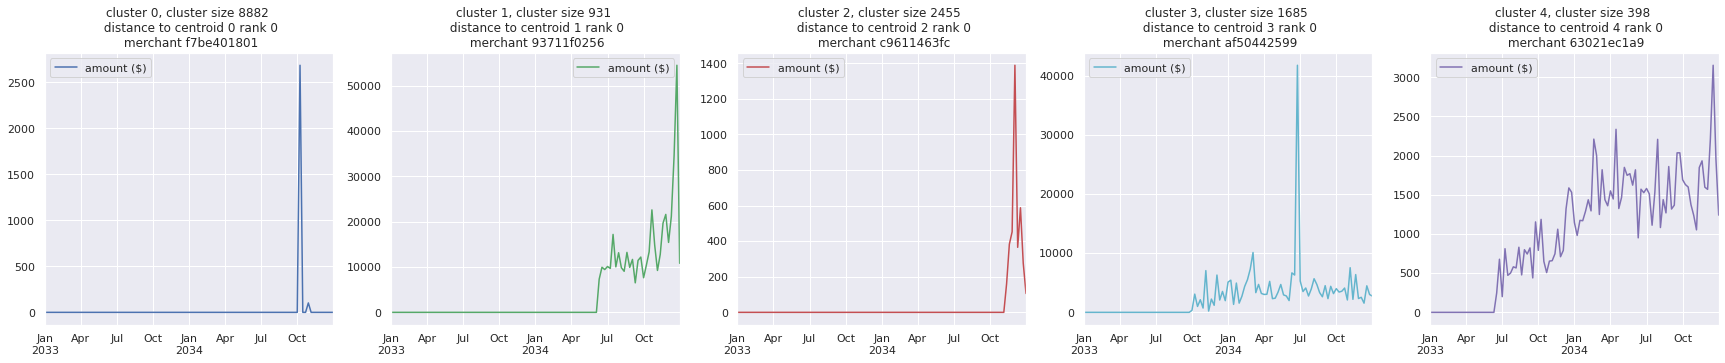

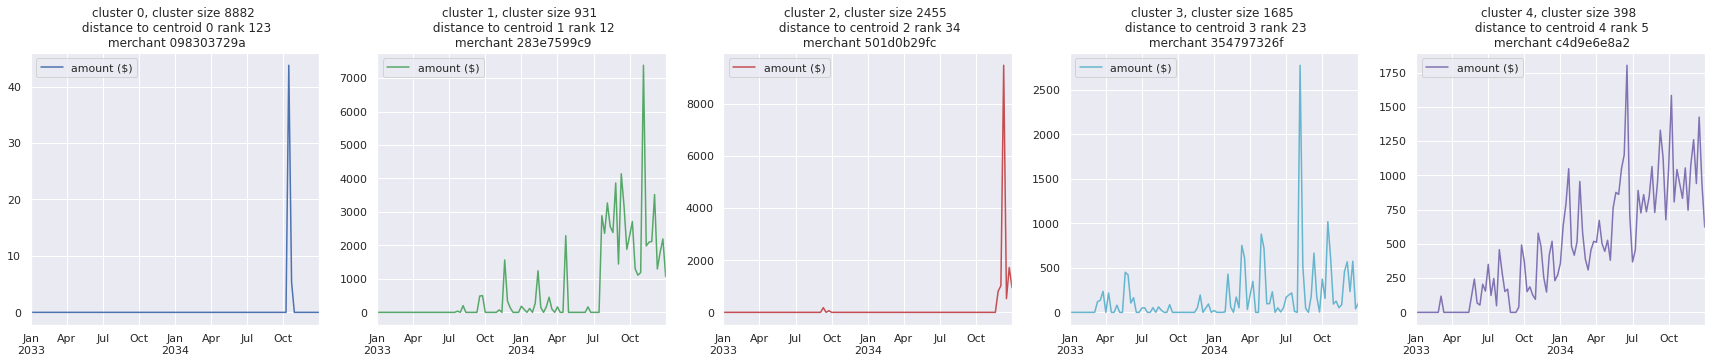

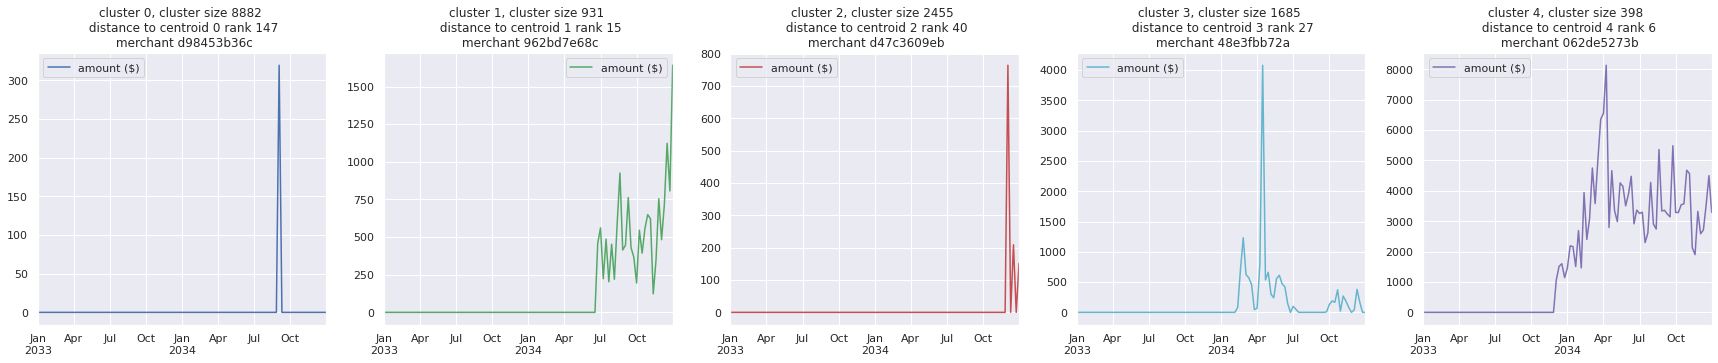

CPU times: user 3.63 s, sys: 74.3 ms, total: 3.7 s
Wall time: 3.64 s


In [10]:
%%time

############################ Describe each cluster by amount and number of transactions #######################################
merchant_describe = []
title_describe = []
for cluster in range(n_clusters):
    merchants_cluster = d[cluster]
    #     merchant_describe.append( sum_merchant.loc[merchants_cluster].to_frame('Total number of transactions description').describe() )
    merchant_describe.append(sum_merchant.loc[merchants_cluster].to_frame('________Total amount description_______').describe().applymap(lambda x: f"{x:.0f}"))
    title_describe.append('cluster ' + str(cluster))

display_side_by_side(merchant_describe, title_describe)

merchant_describe = []
title_describe = []
for cluster in range(n_clusters):
    merchants_cluster = d[cluster]
    merchant_describe.append(count_merchant.loc[merchants_cluster].to_frame('______Total number of transactions______').describe().applymap(lambda x: f"{x:.0f}"))
    title_describe.append('cluster ' + str(cluster))

display_side_by_side(merchant_describe, title_describe)

#######################################################################################################################################################

#######################################################################################################################################################

merchant_describe = []
title_describe = []
for cluster in range(n_clusters):
    merchants_cluster = d[cluster]
    merchant_describe.append(time_interval.loc[merchants_cluster].to_frame('______ Transactions time interval________').describe(datetime_is_numeric=True))
    title_describe.append('cluster ' + str(cluster))

display_side_by_side(merchant_describe, title_describe)

merchant_describe = []
title_describe = []
for cluster in range(n_clusters):
    merchants_cluster = d[cluster]
    merchant_describe.append(time_start.loc[merchants_cluster].to_frame('_________Date first transaction_________').describe(datetime_is_numeric=True))
    title_describe.append('cluster ' + str(cluster))

display_side_by_side(merchant_describe, title_describe)

merchant_describe = []
title_describe = []
for cluster in range(n_clusters):
    merchants_cluster = d[cluster]
    merchant_describe.append(time_end.loc[merchants_cluster].to_frame('_________Date last transaction_________').describe(datetime_is_numeric=True))
    title_describe.append('cluster ' + str(cluster))

display_side_by_side(merchant_describe, title_describe)
#######################################################################################################################################################


################# Plots various samples (number_of_lines) picked randomly among the alpha% closest to each centroid ###################

number_of_lines = 3  # lines refer to the number of lines on the plosts below. each line contains samples for each cluster
select_samples_random = (np.random.uniform(0, 1, number_of_lines)).tolist()

alpha = 5

# creates a dictionary of clusters with number_of_lines samples randomly picked among the alpha% closest samples to the centroid
d_distance = {}
selection_index_list = []
for cluster in range(n_clusters):
    d_centroids = kmeans.transform(data_kmeans)[:, cluster]
    selection_index_list.append([int(line * len(d[cluster]) * alpha / 100) for line in select_samples_random])  # number_of_lines samples randomly picked around each centroid
    index_ordered_from_d_centroid = np.argsort(d_centroids)[::][selection_index_list[cluster]].tolist()
    merchant_list_dist_cluster = np.array(keys_list)[index_ordered_from_d_centroid].tolist()
    d_distance[cluster] = merchant_list_dist_cluster

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'cyan', 'lime', 'coral', 'yellow']

for line in range(number_of_lines):

    fig, axs = plt.subplots(1, n_clusters, figsize=(30, 5))

    for cluster in range(n_clusters):
        merchants_cluster = d_distance[cluster]
        index_ordered_from_d_centroid = selection_index_list[cluster][line]  # random index of a single sample among the alpha% closest samples from the centroid of each cluster
        merchant = merchants_cluster[line]
        dict_merchants[merchant].plot(ax=axs[cluster], color=colors[cluster % len(colors)], use_index=True, y='amount', label='amount ($)') \
            .set_title('cluster ' + str(cluster) + ', cluster size ' + str(len(d[cluster])) + \
                       ' \n distance to centroid ' + str(cluster) + ' rank ' + str(index_ordered_from_d_centroid) + '\n merchant ' + merchant)
    plt.show()

CPU times: user 592 ms, sys: 668 µs, total: 593 ms
Wall time: 592 ms


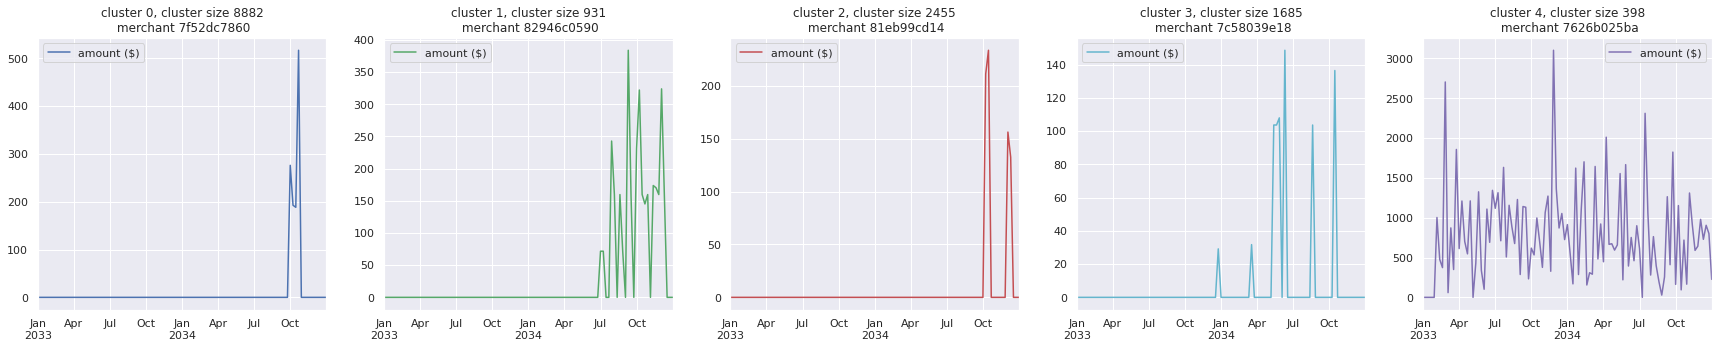

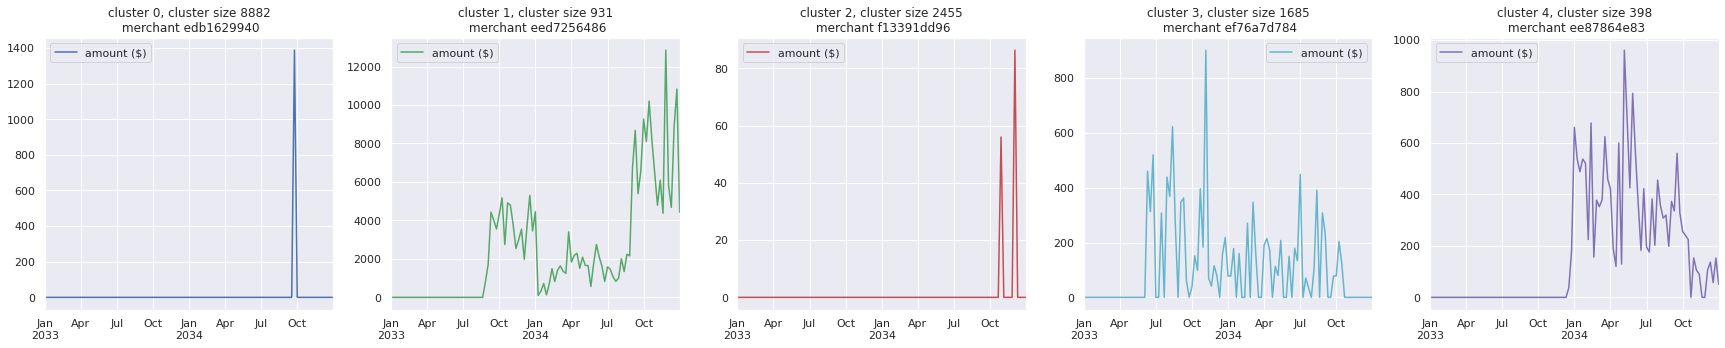

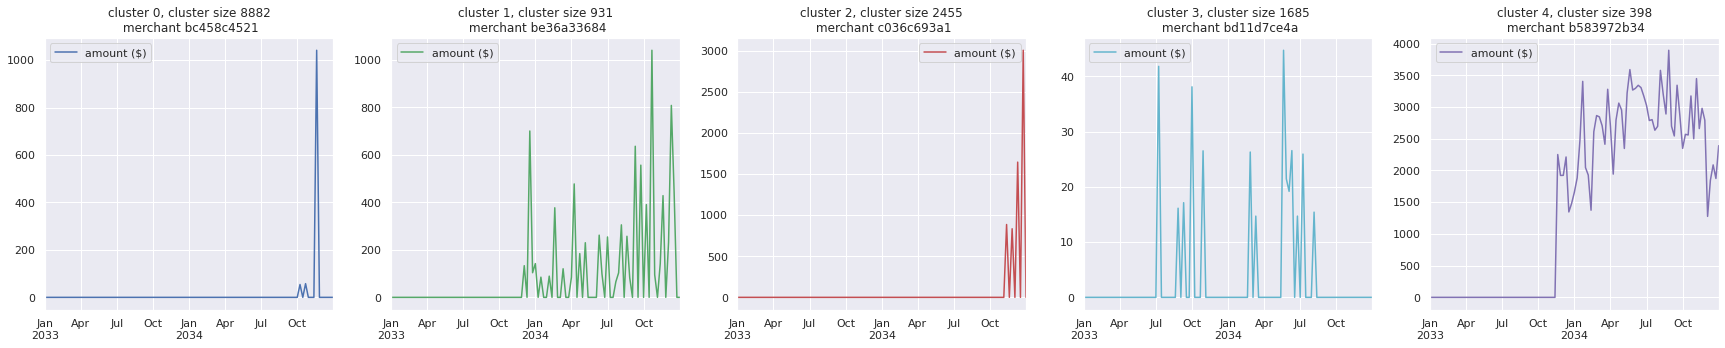

In [11]:
%%time

#####################  Plots samples randomly picked from each cluster  #########################################

number_of_lines = number_of_lines
select_samples_random = (np.random.uniform(0, 1, number_of_lines)).tolist()

for line in range(number_of_lines):

    fig, axs = plt.subplots(1, n_clusters, figsize=(30, 5))

    for cluster in range(n_clusters):
        merchants_cluster = d[cluster]
        cluster_position = int(select_samples_random[line] * len(d[cluster]))  # random position of a single sample among the 10% closest samples from the centroid of each cluster
        merchant = merchants_cluster[cluster_position]
        dict_merchants[merchant].plot(ax=axs[cluster], color=colors[cluster % len(colors)], use_index=True, y='amount', label='amount ($)') \
            .set_title('cluster ' + str(cluster) + ', cluster size ' + str(len(d[cluster])) + '\n merchant ' + merchant)  # ,style='o')

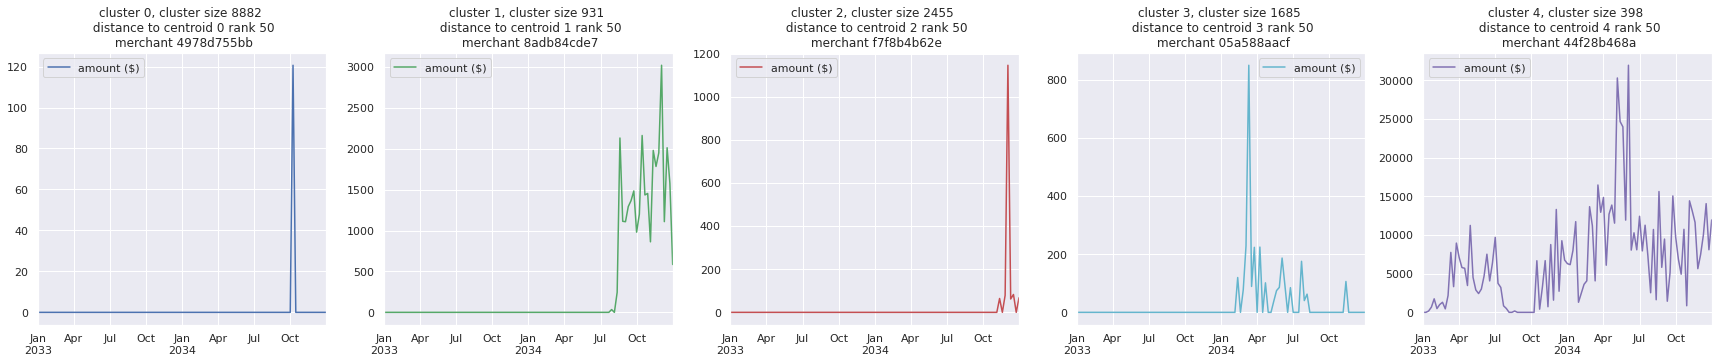

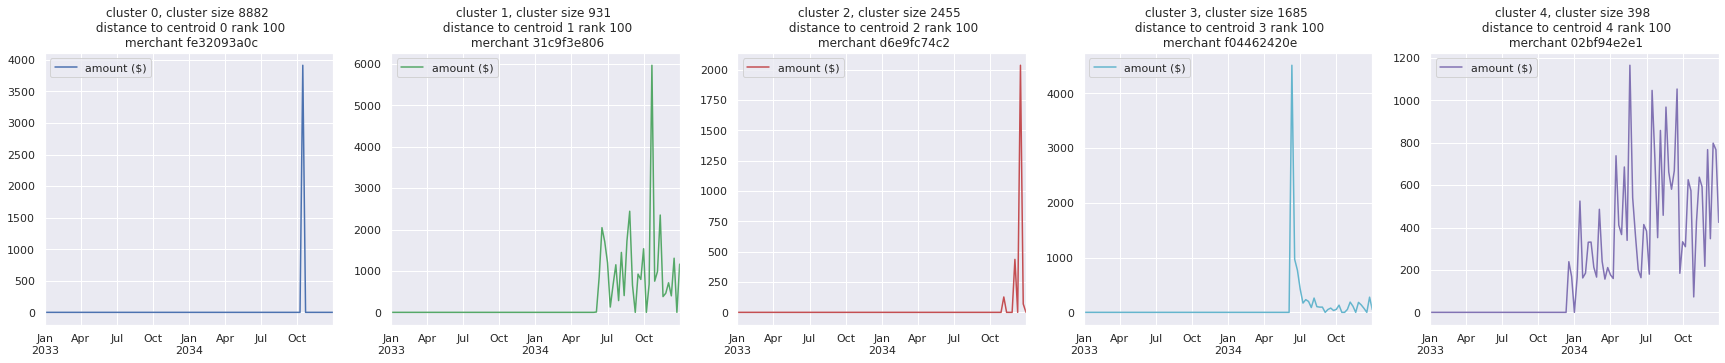

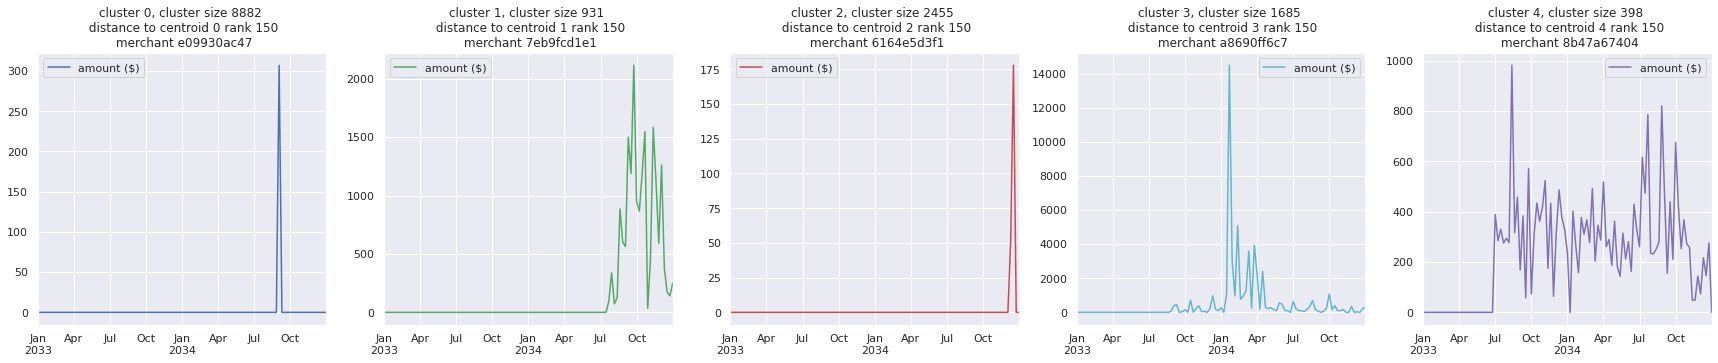

In [12]:
############# Plots samples ordered by distance to the centroids #################################

number_of_lines = number_of_lines

step = 50

# creates a dictionary of clusters with number_of_lines samples ordered by distance to the centroids
d_distance = {}
selection_index_list = []
for cluster in range(n_clusters):
    d_centroids = kmeans.transform(data_kmeans)[:, cluster]
    selection_index_list.append([el for el in range(step, step * number_of_lines + step, step)])  # number_of_lines samples ordered by distance to the centroids
    index_ordered_from_d_centroid = np.argsort(d_centroids)[::][selection_index_list[cluster]].tolist()
    merchant_list_dist_cluster = np.array(keys_list)[index_ordered_from_d_centroid].tolist()
    d_distance[cluster] = merchant_list_dist_cluster

for line in range(number_of_lines):

    fig, axs = plt.subplots(1, n_clusters, figsize=(30, 5))

    for cluster in range(n_clusters):
        merchants_cluster = d_distance[cluster]
        index_ordered_from_d_centroid = selection_index_list[cluster][line]  # random index of a single sample among the alpha% closest samples from the centroid of each cluster
        merchant = merchants_cluster[line]
        dict_merchants[merchant].plot(ax=axs[cluster], color=colors[cluster % len(colors)], use_index=True, y='amount', label='amount ($)') \
            .set_title('cluster ' + str(cluster) + ', cluster size ' + str(len(d[cluster])) + \
                       ' \n distance to centroid ' + str(cluster) + ' rank ' + str(index_ordered_from_d_centroid) + '\n merchant ' + merchant)
    plt.show()

CPU times: user 580 ms, sys: 0 ns, total: 580 ms
Wall time: 578 ms


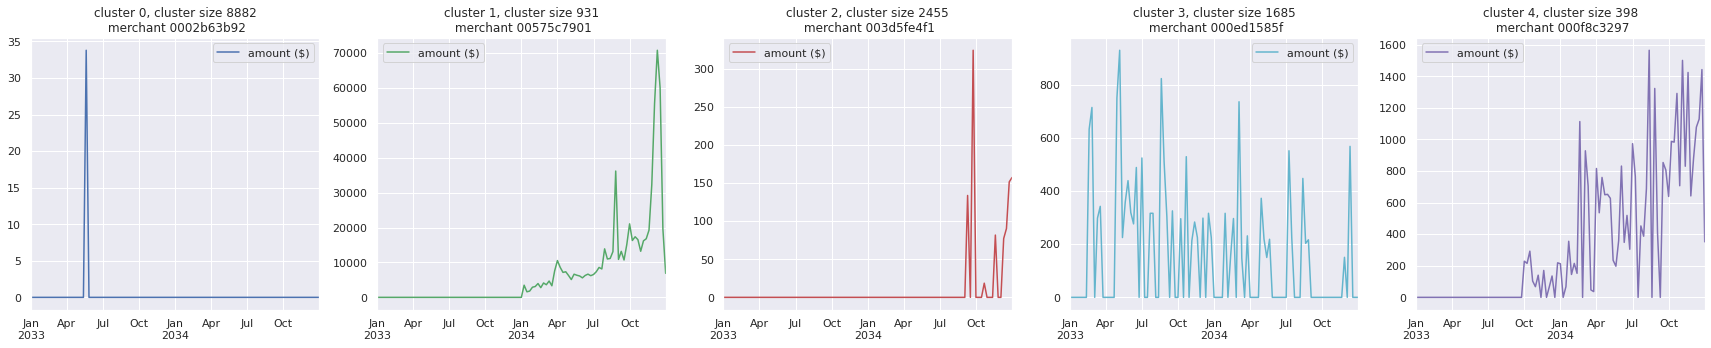

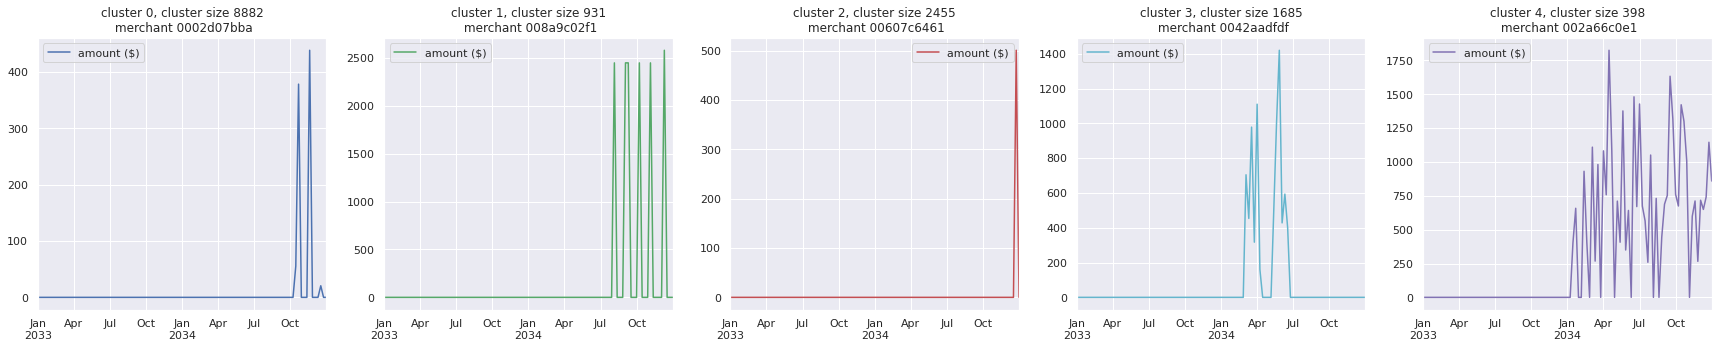

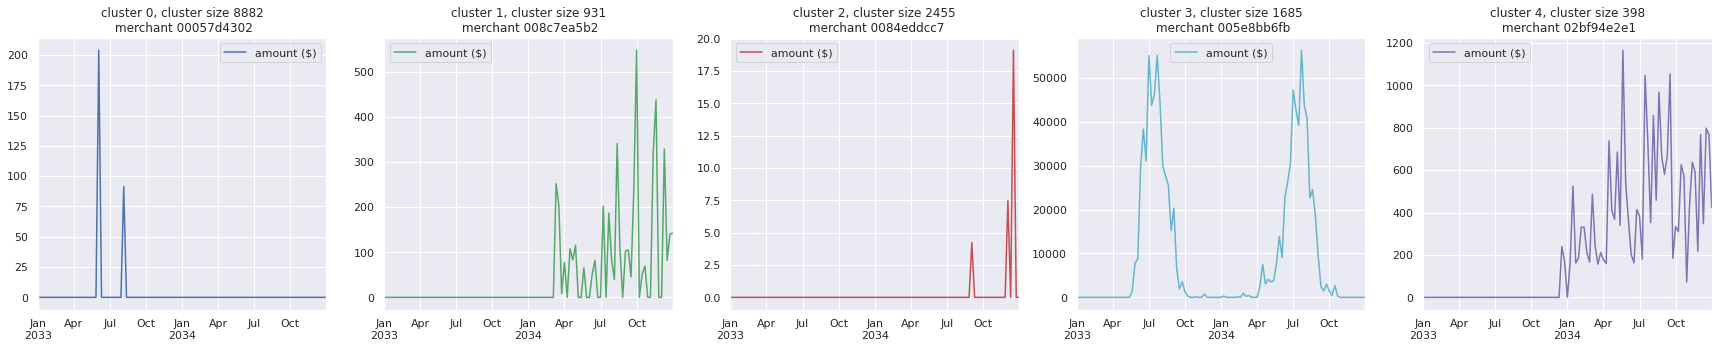

In [13]:
%%time

################ Plots with samples for each cluster ordered by merchant name (no much meaning) #########################


for line in range(number_of_lines):

    fig, axs = plt.subplots(1, n_clusters, figsize=(30, 5))

    for cluster in range(n_clusters):
        merchants_cluster = d[cluster]
        cluster_position = line
        merchant = merchants_cluster[cluster_position]  # picks the position of merchants ordered by its name (this ordering has no meaning)
        dict_merchants[merchant].plot(ax=axs[cluster], color=colors[cluster % len(colors)], use_index=True, y='amount', label='amount ($)') \
            .set_title('cluster ' + str(cluster) + ', cluster size ' + str(len(d[cluster])) + '\n merchant ' + merchant)  # ,style='o')